# 第一周 NMA 课程总结

本周的课程涉及到:

- 计算神经模型的概念与基本类型
- 模型拟合的基本方法
    - 最小二乘法
    - 极大似然法
- 线性模型与广义线性模型的实现
- ICA降维的实现与tSNE方法

In [30]:
# 构建基本运行环境
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import ipywidgets as widgets
import os

## 1. 计算神经模型的概念与基本类型

### 模型的定义

是对现实世界的抽象, 具有简洁和能够控制的优点
 
### 计算模型研究的基本逻辑

观测现象 → 提出模型假设 → 构建模型 → 执行模型做出预期 → 实验验证

### 模型研究问题的不同水平

- 人类行为
- 中枢神经
- 神经系统不同模块
- 神经元网络
- 神经元
- 受体
- 分子

### 不同类型的模型

研究当中使用的模型分为三类:
- What: 描述研究数据
- How: 描述计算机制
- Why: 证实制定模型的计算机制为什么是最优的

举例: 神经元电发放时间间隔模型
- What: 对数函数可以准确描述电发放Interval的分布
- How: LIF 法则能够准确建立神经元的生理机制与Interval的对数分布模式之间的联系
- Why: 使用香农信息熵来证明 Interval 的对数分布模式能够在有限资源的情况下传递尽可能多的信息

## 2. 计算模型建模简单实践

本章我们尝试完整执行一个计算模型研究的基本过程. 一个完整的计算模型研究流程如下:

### 定义研究问题

1. 找到一个实验**现象**并找到相关的待回答的**问题**
2. 了解这个问题当前的研究**进展**
3. 定义问题的基本**切入点**
4. 通过探索性分析, 使用数学工具构建**假设**

### 模型构建

1. 选择合适的建模**工具 (数学模型)**
2. 规划模型构建
3. 完成模型构建


### 模型测试

1. 模型是否能够**表征**认知过程
2. 评估模型的**准确性** (计算模型不关心效率)

### 模型发布

1. 在平台发布模型

In [18]:
# 获取练习数据
fname="W1D2_data.npz"
if not os.path.exists(fname):
  !wget https://osf.io/c5xyf/download -O $fname

filez = np.load(file=fname, allow_pickle=True)
judgments = filez['judgments']
opticflow = filez['opticflow']
vestibular = filez['vestibular']

### 2.1 探索数据以确定研究问题, 并构建研究假设

**现象**: 我们发现在我们从窗口能看到对面的火车时, 火车刚开始启动时, 或当对面当火车开始启动时, 看着窗外的乘车者会产生是外界环境在动而非自己在动的错觉. 我们想知道这种错觉的产生机制.

**实验**:我们假设有两辆火车, 被试坐在其中的一辆火车上. 当其中一辆火车从速度为 0 到 1/m 的过程当中, 我们请被试拨动自己手上的两个代表火车运动速度的滑块, 并记录其移动速度, 从而判断被试的感知是否准确. 每个条件下进行 100 次实验.

接下来我们使用程序来描述这个现象 (What 模型)

#### 2.1.1 探索数据

judgment 数据为实验当中的数据

In [28]:
judgments_table = pd.DataFrame(judgments)
print(judgments_table.head())
print('\nThe dim of judgments is ' + str(judgments.shape))

     0    1    2         3         4
0  0.0  0.0 -1.0  0.018068  0.955705
1  0.0  0.0 -1.0  0.005417  0.918068
2  0.0  0.0 -1.0  0.024356  0.978023
3  0.0  0.0 -1.0  0.005708  0.980809
4  0.0  0.0 -1.0  0.002502  0.961732

The dim of judgments is (200, 5)


这个矩阵为 5 列 200 行, 表示做了 200 次观测, 其中收集到的数据依次为 `[实验条件, 被试是否移动, 外界环境(对面的车)是否移动, 被试判断自己的移动速度, 被试判断对面的移动速度]`

[Text(0.5, 0, 'perceived world motion'), Text(0, 0.5, 'perceived self motion')]

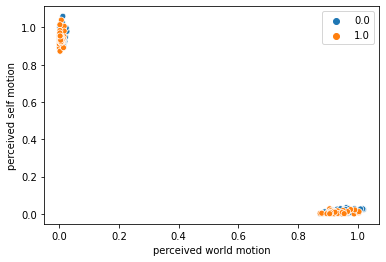

In [36]:
dist_judgment = sb.scatterplot(judgments[:, 3], judgments[:, 4], hue = judgments[:, 0])
dist_judgment.set(xlabel = 'perceived world motion', ylabel = 'perceived self motion')

从图中我们可以看出两种实验条件下的各个观测, 显然被试并不能准确区分两种移动的情况.

我们进而通过阅读文献了解这个领域的**进展**, 得知个体对速度判断来源于两个感知器官的信息, 包括视觉刺激和前庭的感应, 而前庭主要感受到的是加速度信息.

我们可以先模拟数据来看一下两种感知信息的特征.

在物理模型中, 加速度常用 gamma 分布来进行描述. 在有了加速度后, 我们可以使用其来计算速度.

In [37]:
from scipy.stats import gamma
a = gamma.pdf(np.arange(0, 10, 0.001), 2.5, 0)

dt = 0.001
v = np.cumsum(a * dt)

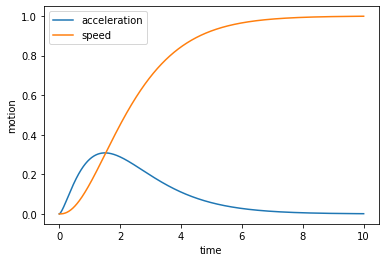

In [41]:
# 把图画出来
time = np.arange(0, 10, 0.001)
plt.plot(time, a, label='acceleration')
plt.plot(time, v, label='speed')
plt.xlabel('time')
plt.ylabel('motion')
plt.legend()
plt.show()

理想情况下通过比较视觉刺激和前庭刺激, 我们可以准确判断出个体自身是否在移动. 但是显然因为头会不停运动, 导致前庭不能感知到任何信号就立刻判断身体正在移动, 而头动和神经系统的传输成为了准确感知加速度的噪声. 从而我们产生一个**假设**, 前庭对加速度感知的信号传入后, 脑存在一个感知的阈值. 只有前庭感受的加速度信息超过了该阈值, 脑才能判断自身正在移动, 而系统噪声造成的误差会导致有的时候加速度超过了这个阈值, 有时则没有, 从而导致判断的失误.

那么是否存在这个噪声? 我们的实验数据当中记录了被试的视觉信息和前庭信息, 我们可以使用这些数据来去了解一下.

In [45]:
# 视觉信息
worldMove_opt = opticflow[0:99, :]
selfMove_opt = opticflow[100:199, :]

# 前庭信息
worldMove_vesti = vestibular[0:99, :]
selfMove_vesti = vestibular[100:199, :]

Opt


Text(0, 0.5, 'Signal')

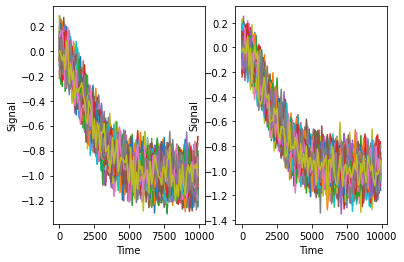

In [54]:
print("Opt")

plt.subplot(1,2,1)
time = np.arange(0, 10000, 100)
for i in range(0, 99):
    plt.plot(time, worldMove_opt[i, :], label = "World Move")
plt.xlabel("Time")
plt.ylabel("Signal")

plt.subplot(1,2,2)
time = np.arange(0, 10000, 100)
for i in range(0, 99):
    plt.plot(time, selfMove_opt[i, :], label = "World Move")
plt.xlabel("Time")
plt.ylabel("Signal")

Vestibular


Text(0, 0.5, 'Signal')

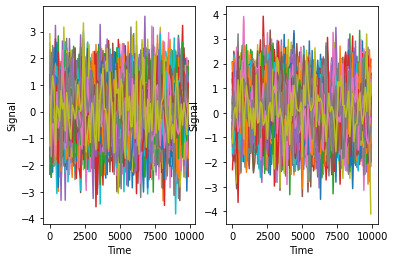

In [55]:
print("Vestibular")

plt.subplot(1,2,1)
time = np.arange(0, 10000, 100)
for i in range(0, 99):
    plt.plot(time, worldMove_vesti[i, :], label = "World Move")
plt.xlabel("Time")
plt.ylabel("Signal")

plt.subplot(1,2,2)
time = np.arange(0, 10000, 100)
for i in range(0, 99):
    plt.plot(time, selfMove_vesti[i, :], label = "World Move")
plt.xlabel("Time")
plt.ylabel("Signal")

我们可以轻易看出, 由于噪声的影响, 两种信号对两种场景均没有区分度, 尤其是对于加速度这种对我们有价值的信息. 当然, 我们在真是世界当中还是能够区分自己移动的信号的, 那势必意味着我们的身体当中对于加速度信息的噪声有去噪的能力. 为了验证我们的假设, 我们可以做一个滤波器来看看查看去噪后的数据是否能够反映出真实的加速度特征.

最简单的去噪器是平均窗口滤波器, 我们尝试来实现它.

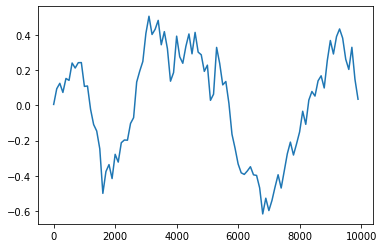

In [91]:
def moving_window(input_signal, window):
    """
    Moving window filter, select each window of hold signal and average them.
    
    args:
        input_signal
        window
        
    outputs:
        filted_signal : A array which come from signal is averaged by window
    """
    
    supplement = np.zeros(window - 1)
    signal = np.concatenate([supplement, input_signal])
    filted_signal = []
    
    for i in range(0, len(input_signal)):
        filted_signal.append(signal[i:(window+i)].mean())
    
    return filted_signal

filted_signal = moving_window(vestibular[1,:], 15)

time = np.arange(0, 10000, 100)
plt.plot(time, filted_signal)

我们发现比起刚才嘈杂的信号, 这个信号的趋势清晰了很多, 而这确实有助于判断身体是否发生了移动.

回到我们刚才的问题上, 我们还认为存在一个阈值来使得身体可以检测是否发生了移动. 假设我们设定一个阈值, 使得信号中检测到这个阈值就会发放我们身体移动了的信号.

In [93]:
def movement_detector(filted_signal, thresholds):
    if max(filted_signal) > thresholds:
        results = 1
    else:
        results = 0
        
    return results

movement_detector(filtered_signal, 0.3)

1

这样我们可以看一下在特定阈值特定窗口下, 这个模型根据被试的前庭信息有多大的可能探测出身体确实在移动:

In [99]:
def detection_ratio(input_signal_matrix, window, thresholds):
    detect_result = []
    
    for i in range(0, len(input_signal_matrix[:,1])):
        filted_signal = moving_window(input_signal_matrix[i,:], window)
        detect_result.append(movement_detector(filted_signal, thresholds))
        
    ratio = np.mean(detect_result)
    return ratio
    
detection_ratio(vestibular, 15, 0.4)

0.815

## 3. 模型估计

当我们构建了一个模型之后, 我们常常需要找到模型当中的最优参数. 当我们选用一个模型的时候, 我们相当于是选择了模型的形状 (能够解决的问题), 但是通过调整模型的参数, 我们才能提高模型所描述的变量和数据的一致性. 

因此模型的参数估计的目标, 是提高模型的解释度.

### 3.1 均方误差 (Mean Squared Error, MSE)

你可能已经熟知最小二乘法作为线性回归模型的参数优化方法, 不过我们在这里可以重新回顾一下.

参数优化的目标是致力于提高模型的解释度, 因此我们需要使用一个数学公式来构建参数与解释度之间的关系, 并通过最优化 (optimization) 来得到最高的解释度. 这个数学公式我们通常称为目标函数. 而均方误差是我们在解决参数优化时最常用的目标函数. 它的公式形式是

$$
\min _{\theta} \frac{1}{N} \sum_{n=1}^{N}\left(y_{n}-\theta x_{n}\right)^{2}
$$

也就是说, 我们需要找到使得估计值与观测值的方差和最小的参数 $\theta$ .

我们接下来构建一个服从 $y = 1.2x$ 线性关系, 并有 `[0,10)` 高斯噪声的数据, 并对它进行估计, 看我们是否可以准确估计出来这些参数.

<AxesSubplot:>

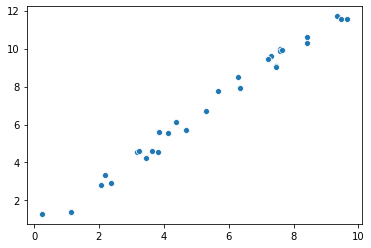

In [100]:
# 生成模拟变量

theta = 1.2
n_sample = 30

x = 10 * np.random.rand(n_sample)
noise = np.random.rand(n_sample)
y = theta * x + noise

sb.scatterplot(x, y)

参数估计的过程:

1. 构建目标函数
2. 对目标函数进行最优化

In [110]:
def mse(x, y, theta_hat):
    y_variance = []
    for i in range(0, len(x)):
        y_variance.append(y[i] - (theta_hat * x[i]))
        
    mse = np.mean(np.square(y_variance))
    
    return mse

theta_hats = [0.75, 1.0, 1.5]
for theta_hat in theta_hats:
  print(f"theta_hat of {theta_hat} has an MSE of {mse(x, y, theta_hat):.2f}")

theta_hat of 0.75 has an MSE of 10.10
theta_hat of 1.0 has an MSE of 2.87
theta_hat of 1.5 has an MSE of 2.05


我们已经构建出了 MSE 和 theta 之间的关系. 进一步我们希望能找到 theta 值的最优解. 因为我们的模拟数据中, 取的 theta 为 1.2 , 我们可以先看看把 最优值和附近的范围 `x = [-2, 4]` 先画出来看看. 

<AxesSubplot:>

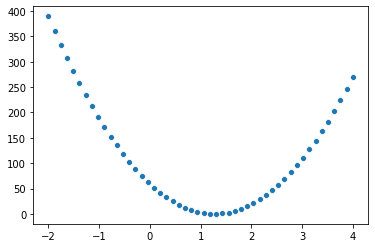

In [111]:
theta_grid = np.linspace(-2, 4)
mse_hat_grid = [mse(x, y, theta_hat) for theta_hat in theta_grid]

sb.scatterplot(theta_grid, mse_hat_grid)